# Trading Day Data Visualization

#### 1) minute chart data from finance.yahoo

In [5]:
from urllib.parse import urlencode
from datetime import datetime, timedelta
import pandas as pd
import requests
import pytz
import json

DATA_TIMEZONE = pytz.timezone("EST")

def get_minute_data(symbol, now):
    
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    end = start.replace(hour=13, minute=0)  
    url = "https://query1.finance.yahoo.com/v7/finance/chart/{}?period1={:.0f}&period2={:.0f}"\
          "&interval=1m&indicators=quote&includeTimestamps=true&"\
          "events=div%7Csplit%7Cearn".format(symbol, start.timestamp(), end.timestamp())
            
    page = requests.get(url)
    result = page.json()['chart']['result']
    if not result:
        print(page.json())
        return
    
    data = result[0]
    quote = data['indicators']['quote'][0]
    if 'timestamp' not in data:
        return
    times = data['timestamp']
    period = data['meta']['currentTradingPeriod']['regular']
    start, end = period['start'], period['end']
    df = pd.DataFrame(quote, index=[datetime.fromtimestamp(t, tz=DATA_TIMEZONE).astimezone(now.tzinfo) for t in times])
    return df


la_tz = pytz.timezone('America/Los_Angeles')
now = datetime.now(tz=la_tz)
minute_data = get_minute_data('BAC', now)
minute_data

,close,high,low,open,volume
2017-03-13 06:30:00-07:00,25.276400,25.299999,25.260000,25.299999,0.0
2017-03-13 06:31:00-07:00,25.240000,25.270000,25.209999,25.270000,564784.0
2017-03-13 06:32:00-07:00,25.270000,25.309000,25.250000,25.250000,363744.0
2017-03-13 06:33:00-07:00,25.299999,25.299999,25.280001,25.280001,274389.0
2017-03-13 06:34:00-07:00,25.250000,25.309999,25.245001,25.306999,269565.0
2017-03-13 06:35:00-07:00,25.229000,25.260000,25.219999,25.250000,456847.0
2017-03-13 06:36:00-07:00,25.200001,25.240000,25.200001,25.230000,455131.0
2017-03-13 06:37:00-07:00,25.184000,25.219999,25.184000,25.209999,399722.0
2017-03-13 06:38:00-07:00,25.205000,25.211000,25.180000,25.190001,204706.0
2017-03-13 06:39:00-07:00,25.190001,25.209999,25.170000,25.209999,179785.0


/usr/local/lib/python3.4/dist-packages/matplotlib-2.0.0b4_3022.gdfd38f7-py3.4-linux-x86_64.egg/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


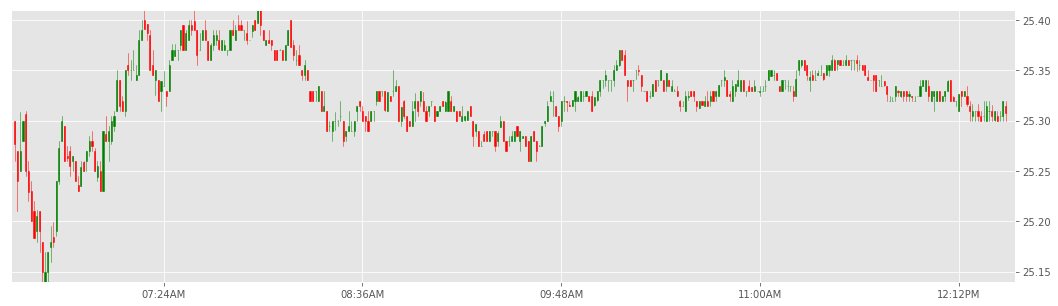

In [6]:
from matplotlib.finance import *
import matplotlib.pyplot as plt
from matplotlib import ticker, style
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY, date2num
    
style.use('ggplot')

def plot_minute_data(data):
    if data is not None:
        fig = plt.figure(figsize=(18, 5))
        ax = plt.subplot(111)
        candlestick_ochl(
            ax, 
            ((date2num(r.Index), r.open, r.close, r.high, r.low) 
             for r in data.itertuples()), 
            width=1/3600,  
            colorup='g',  
            colordown='r',
        )

        x_min, x_max = date2num(data.index.min()) - .001, date2num(data.index.max()) + .001
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(data.low.min(), data.high.max())

        minute_formatter = DateFormatter('%I:%M%p', tz=pytz.timezone('America/Los_Angeles'))
        ax.xaxis.set_major_formatter(minute_formatter)

        ax.yaxis.tick_right()
        plt.show()

plot_minute_data(minute_data)

#### 2) the trade lot data from nasdaq.com

In [7]:
from urllib.parse import quote_plus, urlparse, parse_qs
from lxml import html
import queue
import requests
import threading
import re

def get_proxies():
    with open("approved_proxies.csv", "r") as f:
        proxies = f.read().split()
    return proxies

NUM_THREADS = 100


class ProxyFailException(Exception):
    pass    

def load_in_parrallel(*args, now, scrap_func, save_func):   
    
    tasks = queue.Queue() # queue with arguments for the 'get_transactions' function
    responses = queue.Queue() # queue with raw responses  
    proxies = queue.Queue()
    for p in get_proxies():
        proxies.put(p)
        
    def get_proxy():
        try:
            proxy = proxies.get_nowait()
        except queue.Empty:        
            pass
            #print("Error: you have used all the proxies - this worker will stop")
        else:    
            return proxy
    
    def worker():        
        proxy = get_proxy()        
        while proxy is not None:            
            args = tasks.get()
            if args is None:
                break   
            while True:
                try:
                    scrap_func(proxy, tasks, responses, *args)
                except ProxyFailException as e:
                    proxy = get_proxy()
                    if proxy is None:
                        tasks.put(args)  # put the task back and die
                        break                    
                else:
                    break   
            tasks.task_done()
    

    threads = []
    for i in range(NUM_THREADS):
        t = threading.Thread(target=worker)
        t.start()
        threads.append(t)
        
    tasks.put(args)

    # block until all tasks are done
    tasks.join()

    # stop workers
    for i in range(NUM_THREADS):
        tasks.put(None)

    for t in threads:
        t.join()
        
    return save_func(responses, now)


def get_trades_tree(proxy, stock, time, pageno):
    base_url = "http://www.nasdaq.com/symbol/{symbol}/time-sales?time={time}&pageno={pageno}"
    url = base_url.format(symbol=stock, time=time, pageno=pageno)
    try:
        page_res = requests.get(url, timeout=6, proxies={'http': "http://{}".format(proxy)})
    except Exception as e:
        raise ProxyFailException()        
    else:    
        return html.fromstring(page_res.content)
    
def page_get_lots(tree):
    table = tree.find('.//table[@id="AfterHoursPagingContents_Table"]')
    if table is None:
        raise ProxyFailException('The table is missing')
    else:
        lots = [
            tuple(col.text_content() for col in row) 
            for row in table 
            if row.tag == 'tr'
        ]
        return lots

def pull_trades(proxy, q, r, stock, time, pageno=None):
    tree = get_trades_tree(proxy, stock, time, pageno or 1)
    
    if tree is not None:

        if pageno is None:
            pager = tree.find('.//ul[@id="pager"]')
            if pager is not None:
                page_links = pager.findall('.//a')
                if page_links:
                    href = page_links[-1].attrib['href']
                    parsed_url = urlparse(href)
                    query_params = parse_qs(parsed_url.query)
                    max_page = int(query_params['pageno'][0])
                    
                    for pn in range(1, max_page + 1):
                        q.put((stock, time, pn))
            else:
                raise ProxyFailException('The pager is missing')
                
        for l in page_get_lots(tree):
            r.put(l)
            
def save_trades(r, now):
    df = pd.DataFrame([], columns=('Time', 'Price', 'Volume'))
    i = 0
    while True:
        try:
            time, price, volume = r.get(block=False)
        except queue.Empty:
            break
        else:
            df.loc[i] = re.sub(r'[^\d:]+', '', time), float(re.sub(r'[^\d\.]+', '', price)), int(re.sub(r'[^\d]+', '', volume))
            i += 1
    return df

In [8]:
def get_trade_lots(symbol, now, time):    
    df = load_in_parrallel(symbol, time, now=now, scrap_func=pull_trades, save_func=save_trades,) 
    df = df[df.Volume >= 1000]
    df['Minute'] = df.Time.str[:5]
    df['Cost'] = df.Price * df.Volume * 100   
    df['TimePeriod'] = time
    df = df.sort_values(by=['Time'], ascending=False)
    return df

df = get_trade_lots('BAC', now, time=1)
df

,Time,Price,Volume,Minute,Cost,TimePeriod
4290,15:32:18,25.2700,1710.0,15:32,4321170.0,1
4291,15:32:18,25.2700,3000.0,15:32,7581000.0,1
4293,15:32:18,25.2710,3000.0,15:32,7581300.0,1
4299,15:32:18,25.2800,6434.0,15:32,16265152.0,1
4305,15:32:18,25.2800,1000.0,15:32,2528000.0,1
4345,15:32:13,25.2890,1000.0,15:32,2528900.0,1
4241,15:32:13,25.2890,1000.0,15:32,2528900.0,1
4330,15:32:13,25.2890,1000.0,15:32,2528900.0,1
4335,15:32:07,25.2890,1000.0,15:32,2528900.0,1
4246,15:32:07,25.2890,1000.0,15:32,2528900.0,1


In [6]:
# This function will display the table
from IPython.display import display, HTML
from datetime import datetime
import numpy as np
import math


def display_trade_lots_tables(data, minute_data, now):
    if data is None or not len(data):
        print("Trade lots list is empty")
        return
    data['Count'] = 1      
    def apply_minute_data(df):
        eastern = pytz.timezone('US/Eastern')
        def get_minute_data(row):
            minute = row.Minute if 'Minute' in df.dtypes.keys() else row.name 
            hour, minute = minute.split(':')
            time = now.replace(hour=int(hour), minute=int(minute), second=0, microsecond=0, tzinfo=eastern)
            time = datetime(
                now.year, now.month, now.day, 
                hour=int(hour), minute=int(minute), second=0, microsecond=0,
            )        
            time = eastern.localize(time)

            if minute_data is not None and time in minute_data.index:
                md = minute_data.loc[time]
                open, close = md.open, md.close
            else:
                open = close = None        
            return open, close    

        df['Open'], df['Close'] = zip(*df.apply(get_minute_data, axis=1))
        df['CloseByOpen'] = (df.Close / df.Open - 1) * 100
    
    def display_table(rows):
        headers = ("Time", "Open", "Close", "Close/Open", "Shares", "Cost", "# of lots")
        row = "<td>{time}</td><td>{open}</td><td>{close}</td><td>{co_tab} {close_by_open}</td>"\
              "<td>{vo_tab} {volume:,.0f}</td><td>{cost_tab} {cost:,.0f}</td><td>{count_tab} {count}</td>"
        table_rows = (row.format(**kwargs) for kwargs in rows) 
        display(
            HTML(
                '<table><tr><th>{}</th></tr><tr>{}</tr></table>'.format(
                    "</th><th>".join(headers),
                    "</tr><tr>".join(table_rows)
                )
            )
        )  
    
    
    display(HTML("<h4>AGGREGATED TRADING FEED BY MINUTE</h4>"))
    sum_data = data.groupby(['Minute'])['Cost', 'Volume', 'Count'].sum()
    apply_minute_data(sum_data)
    sum_data = sum_data.sort_index(ascending=False)
    
    def get_tab(value, min_value, max_value, color):
        n = 0        
        if not pd.isnull(value):
            diff = max_value - min_value
            if diff:
                n = math.ceil((value - min_value) / diff * 20)
                
        return '<div style="float:left;background-color:{};height=20px;" >{}</div>&nbsp;'.format(
            "green" if color >= 0 else "red",
            "&nbsp;" * (n + 1), 
        )
    min_co, max_co = sum_data.CloseByOpen.min(), sum_data.CloseByOpen.max()
    min_vo, max_vo = sum_data.Volume.min(), sum_data.Volume.max()
    min_cost, max_cost = sum_data.Cost.min(), sum_data.Cost.max()
    min_count, max_count = sum_data.Count.min(), sum_data.Count.max()
    rows = (dict(time=r.Index, 
                 open="{:.4f}".format(r.Open) if r.Open else r.Open, 
                 close="{:.4f}".format(r.Close) if r.Close else r.Close, 
                 close_by_open="{:.4f}".format(r.CloseByOpen) if r.CloseByOpen else r.CloseByOpen,                 
                 volume=r.Volume, cost=r.Cost, count=r.Count,
                 co_tab=get_tab(r.CloseByOpen, min_co, max_co, r.CloseByOpen),
                 vo_tab=get_tab(r.Volume, min_vo, max_vo, r.CloseByOpen),
                 cost_tab=get_tab(r.Cost, min_cost, max_cost, r.CloseByOpen),
                 count_tab=get_tab(r.Count, min_count, max_count, r.CloseByOpen),
                ) 
            for r in sum_data.itertuples())
    display_table(rows)
    
    display(HTML("<h4>SEGREGATED TRADING FEED BY MINUTE</h4>"))
    apply_minute_data(data)
    min_co, max_co = data.CloseByOpen.min(), data.CloseByOpen.max()
    min_vo, max_vo = data.Volume.min(), data.Volume.max()
    min_cost, max_cost = data.Cost.min(), data.Cost.max()
    min_count, max_count = data.Count.min(), data.Count.max()
    rows = (dict(time=r.Minute, 
                 open="{:.4f}".format(r.Open) if r.Open else r.Open, 
                 close="{:.4f}".format(r.Close) if r.Close else r.Close, 
                 close_by_open="{:.4f}".format(r.CloseByOpen) if r.CloseByOpen else r.CloseByOpen,                  
                 volume=r.Volume, cost=r.Cost, count=r.Count,
                 co_tab=get_tab(r.CloseByOpen, min_co, max_co, r.CloseByOpen),
                 vo_tab=get_tab(r.Volume, min_vo, max_vo, r.CloseByOpen),
                 cost_tab=get_tab(r.Cost, min_cost, max_cost, r.CloseByOpen),
                 count_tab=get_tab(r.Count, min_count, max_count, r.CloseByOpen),
                )
            for r in data.itertuples())
    display_table(rows)
    
    
#     return sum_data 

display_trade_lots_tables(df, minute_data, now)

Time,Open,Close,Close/Open,Shares,Cost,# of lots
15:59,25.3150,25.3200,0.0197,"321,845","814,731,043",75
09:59,25.4600,25.4500,-0.0393,"135,150","344,089,664",29
09:58,25.4700,25.4522,-0.0699,"57,982","147,619,653",20
09:57,25.4800,25.4799,-0.0004,"18,181","46,331,486",11
09:56,25.4550,25.4800,0.0982,"98,091","249,830,235",21
09:55,25.4800,25.4500,-0.1177,"77,300","196,795,920",32
09:54,25.4800,25.4800,0.0,"121,909","310,643,224",32
09:53,25.4900,25.4800,-0.0392,"131,744","335,837,534",41
09:52,25.4600,25.4950,0.1375,"70,696","180,211,812",31
09:51,25.4493,25.4600,0.0420,"89,360","227,463,190",26


Time,Open,Close,Close/Open,Shares,Cost,# of lots
15:59,25.3150,25.3200,0.0197,"4,000","10,124,880",1
15:59,25.3150,25.3200,0.0197,"15,850","40,132,200",1
15:59,25.3150,25.3200,0.0197,"4,000","10,124,880",1
15:59,25.3150,25.3200,0.0197,"15,850","40,132,200",1
15:59,25.3150,25.3200,0.0197,"4,000","10,124,880",1
15:59,25.3150,25.3200,0.0197,"15,850","40,132,200",1
15:59,25.3150,25.3200,0.0197,"4,000","10,124,880",1
15:59,25.3150,25.3200,0.0197,"15,850","40,132,200",1
15:59,25.3150,25.3200,0.0197,"4,000","10,124,880",1
15:59,25.3150,25.3200,0.0197,"15,850","40,132,200",1


In [ ]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from matplotlib import ticker, dates as mdates
import numpy as np
import pytz
from time import sleep
import heapq
import math

tz = pytz.timezone('America/Los_Angeles')
STOCK_SYMBOL = 'SQ'

last_time = None
trade_lots = None
lots_times = (
    (6, 59),
    (7, 29),
    (7, 59),
    (8, 29),
    (8, 59),
    (9, 29),
    (9, 59),
    (10,29),
    (10, 59),
    (11, 29),
    (11, 59),
    (12, 29),
    (13, 0),
)
current_time_period = 1


while True:    
    now = datetime.now(tz=tz)
    start = now.replace(hour=6, minute=30, second=0, microsecond=0)
    stop = start.replace(hour=13, minute=0)
    
    if start <= now <= stop: # proper time for getting data
        
        if last_time: # no more often than once per minute
            diff = 60 - (now - last_time).seconds            
            if diff > 0:
                sleep(diff)
        
        # GETTING DATA
        minute_data = get_minute_data(STOCK_SYMBOL, now)        
        
        leh, lem = lots_times[current_time_period - 1]
        time_range_end = start.replace(hour=leh, minute=lem)
        if last_time and last_time > time_range_end:
            current_time_period += 1
        
        response = get_trade_lots(STOCK_SYMBOL, now, current_time_period)
        res_len = len(response)
        if res_len:            
            if trade_lots is not None:
                trade_lots = trade_lots[trade_lots.TimePeriod != current_time_period]
                trade_lots = response.append(trade_lots, ignore_index=True)
            else:
                trade_lots = response

        # DISPLAYING DATA
        clear_output()
        print('1) minute chart data from finance.yahoo')
        plot_minute_data(minute_data)
        
        print('2) the trade lot data from nasdaq.com')
        display_trade_lots_tables(trade_lots, minute_data, now)    
        
        print("last update", now)
        print("prev update", last_time) 
        print("update time", datetime.now(tz=tz) - now)
        last_time = now        
    else: 
        current_time_period = 1
        trade_lots = None
        
        if now < start:
            diff = start - now
            print("time to start:", diff)
            
        else:
            start_tommorow = start + timedelta(days=1)
            print("start tommorow at", start_tommorow)
            diff = start_tommorow - now
        
        sleep(diff.seconds + diff.microseconds * 0.1 ** 6)